# music reviews conditioned on songs

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print('cuda.is_available:', torch.cuda.is_available())
print(f'available: {torch.cuda.device_count()}; current: {torch.cuda.current_device()}')
DEVICE = torch.device(f'cuda:{torch.cuda.current_device()}' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
print('pytorch', torch.__version__)

cuda.is_available: True
available: 1; current: 0
cuda:0
pytorch 0.4.0


In [2]:
import pdb
from IPython.core.debugger import set_trace

## Data

In [3]:
import dill as pickle
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import spacy

BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, '..', 'datasets')

DATA_F = os.path.join(DATA_DIR, f'reviews_and_metadata_5yrs.json')
DATA_DF = pd.read_json(DATA_F)

In [4]:
DATA_DF.content[0]

'New Music\nMt. Joy reached out to us with the powerful sentiment of their alt-folk\nanthem, "Silver Lining." The song is about coping with the feelings of loss\nafter losing friends to addiction. The heavy subject matter is touching and\neloquently-delivered... And its hard to deny the powerful chorus of "But if it\'s\nthe drugs, the women, the wine, the weed." Recommended for fans of Mumford &\nSons, Edward Sharpe, or Noah and the Whale.\nDrop Mt. Joy a like on Instagram while you\'re at it.'

In [5]:
# remove all double-quotation marks
DATA_DF.content = DATA_DF.content.apply(lambda x: x.replace('"', ''))
DATA_DF.content[0]

"New Music\nMt. Joy reached out to us with the powerful sentiment of their alt-folk\nanthem, Silver Lining. The song is about coping with the feelings of loss\nafter losing friends to addiction. The heavy subject matter is touching and\neloquently-delivered... And its hard to deny the powerful chorus of But if it's\nthe drugs, the women, the wine, the weed. Recommended for fans of Mumford &\nSons, Edward Sharpe, or Noah and the Whale.\nDrop Mt. Joy a like on Instagram while you're at it."

In [6]:
DATA_DF = DATA_DF.assign(genres_str=lambda x: None)
DATA_DF.genres_str = DATA_DF.genres.apply(lambda x: '/'.join(x) if x is not None else 'none')

In [7]:
# build special genre_content column for conditioned reviews later on
# note that we are also removing punctuation and spacing in genre names for this
#import re
#import string

#GENRE_REGEX = re.compile(f'[{re.escape(string.punctuation)}{re.escape(string.whitespace)}]')

#DATA_DF = DATA_DF.assign(genre_content=lambda x: None)
#DATA_DF.genre_content = DATA_DF.genres.apply(lambda x: ' '.join([f'genre{GENRE_REGEX.sub("", g.upper())}' for g in x])  if x is not None else 'none') + ' ' + DATA_DF.content
#DATA_DF.genre_content.head()

In [8]:
SAMPLE_DF = DATA_DF.sample(250) # overfit to 250 songs
TRAIN_DF, VAL_DF = train_test_split(SAMPLE_DF, test_size=0.2, random_state=42)
SAMPLE_DF.head()

,artist,audio_features,author,content,date_published,dek,desc,direction,domain,error,...,pages_rendered,post_title,posturl,rendered_pages,sitename,song_title,spotify_id,total_pages,word_count,genres_str
12143,Kero Kero Bonito,"{'danceability': 0.848, 'energy': 0.734, 'key'...",None,Follow on Facebook Follow on Twitter Follow on...,None,NaN,"\n\n“Break”, the sixth track on Kero Kero Boni...",ltr,www.gorillavsbear.net,NaN,...,NaN,Kero Kero Bonito – Break,http://www.gorillavsbear.net/kero-kero-bonito-...,1.0,Gorilla Vs. Bear,Break,6u4xZnL4W0YSLXw24k2zlJ,1,203,pop
24737,Wafia,"{'danceability': 0.731, 'energy': 0.397, 'key'...",Kara Bertoncini,"This here woman is a certified artiste, and on...",2017-12-20T00:00:00.000Z,NaN,\n\n?\n\n,ltr,acidstag.com,NaN,...,NaN,Wafia – ‘Only Love’,https://acidstag.com/2017/12/20/wafia-only-love/,1.0,acid stag,Only Love,7GuVmtXJ6fBhvkPO5tFblN,1,171,pop
39962,Aeroplane (Official),None,Acid Stag,Last week's Friday MixTape #234 opened with a ...,2015-04-16T00:00:00.000Z,NaN,None,ltr,acidstag.com,NaN,...,NaN,Aeroplane – Let’s Get Slow (ft. Benjamin Diamo...,http://acidstag.com/2015/04/16/aeroplane-lets-...,1.0,acid stag,Let's Get Slow Feat. Benjamin Diamond,None,1,81,none
45752,KATE BOY,"{'danceability': 0.766, 'energy': 0.795, 'key'...",None,"In the past week, I've made an effort to liste...",None,NaN,\n\n?\n\n,ltr,www.indieshuffle.com,NaN,...,NaN,Kate Boy - Self Control :,http://www.indieshuffle.com/kate-boy-self-cont...,1.0,Indie Shuffle,Self Control,7nO2pVDwUASgEUwQPaHYo9,1,325,pop
30500,VIC MENSA & JOEY PURP,None,None,Produced by Papi Beatz and Jake Osmun.\nWhile ...,None,NaN,None,ltr,www.fakeshoredrive.com,NaN,...,NaN,Vic Mensa & Joey Purp – 773 Freestyle,http://www.fakeshoredrive.com/2016/08/vic-mens...,1.0,Fake Shore Drive,773 FREESTYLE,None,1,59,none


In [9]:
SAMPLE_DF.groupby('genres_str').size().sort_values(ascending=False) # DATA_DF

genres_str
pop                         86
none                        84
rap                         23
rock                        19
non-music                   17
r-b                         10
rock/pop                     5
rap/rock/country/r-b/pop     2
non-music/rock               2
rap/rock                     1
r-b/pop                      1
dtype: int64

**TODO**: `non-music` genre means what in this context?

## LM data

In [10]:
#!python -m spacy download en
spacy_tok = spacy.load('en')

In [11]:
BPTT = 35 #70       # like the 'n' in n-gram, or order
BS = 64         # batch size
N_EMB = 300     # size of embedding vector
N_HIDDEN = 1024  # size of hidden activations per layer
N_LAYERS = 2

In [12]:
from torchtext import vocab, data

from fastai.nlp import *
from fastai.lm_rnn import *

TEXT = data.Field(lower=True, tokenize='spacy')

md = LanguageModelData.from_dataframes('.', TEXT, 'content', TRAIN_DF, VAL_DF, bs=BS, bptt=BPTT, min_freq=3)

len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(14, 1478, 1, 33802)

In [13]:
len(TRAIN_DF), len(VAL_DF)

(200, 50)

_Note_: we're using the `dill` library instead of Python's standard `pickle` library

In [14]:
MODEL_DIR = os.path.join(DATA_DIR, 'models')
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
#pickle.dump(TEXT, open(os.path.join(MODEL_DIR, 'TEXT.pkl'), 'wb'))

In [15]:
TEXT.vocab.itos[:12]

['<unk>', '<pad>', '\n', ',', '.', 'the', 'and', 'a', 'of', 'to', '-', "'s"]

In [16]:
TEXT.vocab.stoi['and']

6

In [17]:
print(md.trn_ds[0].text[:12])
print(TEXT.numericalize([md.trn_ds[0].text[:12]]))

['all', 'the', 'time', '-', 'bahamas', '.', '\n', 'bahamas', 'is', 'the', 'solo', 'project']
tensor([[  50],
        [   5],
        [ 105],
        [  10],
        [   0],
        [   4],
        [   2],
        [   0],
        [  13],
        [   5],
        [ 439],
        [ 496]], device='cuda:0')


In [18]:
md.trn_dl.data

tensor([[   50,     0,     2,  ...,  1234,     8,  1429],
        [    5,    78,     0,  ...,     3,     5,     8],
        [  105,    24,    11,  ...,     0,     0,   436],
        ...,
        [    2,     0,    35,  ...,     2,  1169,     9],
        [    0,     0,     0,  ...,  1139,    86,    86],
        [    3,   103,     4,  ...,     0,    83,     3]], device='cuda:0')

## reviews without conditioning

In [19]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_emb, batch_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, n_emb)
        self.rnn = nn.LSTM(n_emb, hidden_size, num_layers, dropout=0.5)
        self.l_out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.init_hidden(batch_size)
        
    def forward(self, inputs):
        bs = inputs[0].size(0)
        if self.hidden[0].size(1) != bs: self.init_hidden(bs)
            
        inputs = self.embedding(inputs)
        output, hidden = self.rnn(inputs, self.hidden)
        self.hidden = [h.detach() for h in hidden]
        output = self.l_out(output)
        output = self.softmax(output)
        
        return output.view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.batch_size = bs
        self.hidden = (V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)),
                  V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)))

In [20]:
def sample_fast(model, seed='the song', sample=True):
    idxs = TEXT.numericalize([[tok.text for tok in spacy_tok(seed)]])
    p = model(VV(idxs.transpose(0,1)))
    if sample:
        r = torch.multinomial(p[-1].exp(), 1)
        return TEXT.vocab.itos[to_np(r)[0]]
    
    r = p[-1].topk(1)[1][0]
    return TEXT.vocab.itos[r.item()]

def sample_fast_n(model, n, seed='the song', sample=True):
    res = seed
    for i in range(n):
        w = sample_fast(model, seed, sample)
        res += w + ' '
        seed = seed[1:] + w
    print(res)

In [21]:
# Note: check BPTT value if fit throw "ZeroDivisionError: Weights sum to zero, can't be normalized"
# in validate method of fastai/model.py

lstm = LSTM(md.nt, N_HIDDEN, N_EMB, BS, N_LAYERS).to(DEVICE)
lo = LayerOptimizer(optim.Adam, lstm, 1e-2, 1e-6)

losses = []
for i in range(10):
    cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2)]
    losses.append(fit(lstm, md, 10, lo.opt, F.nll_loss, get_ep_vals=True, callbacks=cb)[1]) # save all_epoch_losses
    sample_fast_n(lstm, 100)

epoch      trn_loss   val_loss                            
    0      6.094688   4.93106   
    1      5.698168   4.836139                            
    2      5.481555   4.756642                            
    3      5.361525   4.667967                            
    4      5.236688   4.563368                            
    5      5.10469    4.511533                            
    6      4.981238   4.505965                            
    7      4.894971   4.405269                            
    8      4.773066   4.378018                            
    9      4.624234   4.321089                            

the songfacebook & <unk> summer and <unk> layers eos > a listening <unk> , and long 
 mellow most , which twitter . it rapper ! 

 do , _ on based and sounds . we in are 
 comment < eos > electronic announced . did of , <unk> <unk> style to <unk> ooh facebook fits and a all and and dates <unk> our kings if house . absolutely <unk> saying eos 
 she source autograf at into , 

epoch      trn_loss   val_loss                            
    0      3.973274   4.262305  
    1      3.89364    4.257208                            
    2      3.747831   4.266848                            
    3      3.686483   4.293946                            
    4      3.584754   4.35751                             
    5      3.45137    4.352399                            
    6      3.295845   4.338258                            
    7      3.181697   4.520678                            
    8      3.081051   4.604191                            
    9      2.975921   4.563194                            

the song> post eos because little really 's leeds <unk> eye 
 <unk> disco <unk> <unk> vocals - on own night 
 <unk> driven <unk> dream it <unk> comments the service 
 <unk> <unk> star use and - certainly summer <unk> 02 songwriter of <unk> ambient . remixes to , <unk> press musical 22 
 categories : 
 <unk> install eos saying a duo 
 hop ? day and - <unk> has broken his wit

epoch      trn_loss   val_loss                            
    0      2.413027   4.611525  
    1      2.195963   4.784737                            
    2      1.999579   4.815695                            
    3      1.944886   4.929777                            
    4      1.838055   4.984781                            
    5      1.671993   5.147793                            
    6      1.511477   5.123003                            
    7      1.420317   5.240688                            
    8      1.351933   5.497817                            
    9      1.239372   5.554249                            

the songeos and , <unk> ping think <unk> do n't a by < eos you , proof 
 categories to <unk> our upcoming turn to and to , psychedelic chill and electronic for by <unk> willowbank , builds the day , <unk> debut complexity <unk> sufjan impressive <unk> sydney eos producer - and original film that , and see are look ( see that 
 categories : ( us good through john in track lo

epoch      trn_loss   val_loss                             
    0      0.776127   5.601926  
    1      0.713322   5.749817                             
    2      0.659528   5.721608                             
    3      0.625644   5.833487                             
    4      0.562305   5.991128                             
    5      0.50063    6.0316                               
    6      0.466758   5.985365                             
    7      0.42315    6.166137                             
    8      0.383686   6.309243                             
    9      0.349459   6.384619                             

the songeos > <unk> <unk> loading ... ' stuck ' maybe . there / - - 's <unk> us , <unk> head <unk> roosevelt via the and of plenty . easy coin that has level - at <unk> some pop the on . all synth tracks and of 's <unk> instant <unk> loading ) 
 may vallis punk ( some - , <unk> some <unk> our song is post and - on <unk> canadian - punk a 
 <unk> aussie <unk> brook

epoch      trn_loss   val_loss                             
    0      0.199565   6.313917  
    1      0.194524   6.455076                             
    2      0.180449   6.421834                             
    3      0.200395   6.482701                             
    4      0.208561   6.463401                             
    5      0.187175   6.488366                             
    6      0.165673   6.473318                             
    7      0.158718   6.597801                             
    8      0.147667   6.619856                             
    9      0.133757   6.633027                            

the songeos > worst <unk> our song of and and and . 
 the euphoric <unk> break i pop free and with turning <unk> tuned r&b picture pop and for . 
 <unk> tensnake eos > two inch and for and and - track from the with to . he track and of , 4/18/2018 disco 
 <unk> chvrches 's <unk> most recently the has , but donate at 
 brand categories pretty for with and . also syn

epoch      trn_loss   val_loss                              
    0      0.085362   6.685131  
    1      0.168071   6.670651                              
    2      0.125427   6.683856                             
    3      0.110747   6.704472                             
    4      0.112026   6.7677                               
    5      0.096427   6.761841                              
    6      0.088876   6.72772                               
    7      0.0842     6.784665                              
    8      0.079732   6.897121                              
    9      0.077822   6.823378                              

the songeos > hallucinating eos december and and ( twitter   and 
 90 's voice track and - - - at <unk> free originally at . 
 rey and - and his yes people 
 <unk> our song show to . i and its 
 starting for on . it - 
 <unk> ny - us twitter - west forthcoming piece beat show 's <unk> action a a and , deep city songs - and be yes and or control . pre then w

epoch      trn_loss   val_loss                              
    0      0.05567    6.809559  
    1      0.066644   6.799062                              
    2      0.063803   6.843187                              
    3      0.056592   6.876767                              
    4      0.05646    6.839805                              
    5      0.05234    6.879427                              
    6      0.057058   6.890599                              
    7      0.052943   6.93596                               
    8      0.054029   6.900713                             
    9      0.050283   6.922991                              

the songeos be and and heat ( head and -- too categories , you turning including . there too and . you and and but : listen ... to <unk> some floor live 
 <unk> church eos a 
 .com throw artists / . ( get any the top made and and too . wafia and ( get like and 
 <unk> nature with with . you original true and and too . < eos loading - - to <unk> your car m

epoch      trn_loss   val_loss                              
    0      0.038983   6.938753  
    1      0.072699   6.905916                              
    2      0.05667    6.973045                              
    3      0.055911   6.953                                 
    4      0.062477   6.938053                              
    5      0.061475   6.961046                              
    6      0.055278   6.984157                              
    7      0.04969    7.00937                               
    8      0.089896   6.977674                              
    9      0.077576   6.884902                              

the songeos > sufjan record . these those and and and , and and and and . i me with and , but = and my daunt for ( get native around . it punk and . 
 while a the with too 
 your car more and 
 <unk> loading ... 
 <unk> chvrches eos for with , maggie rogers and 
 <unk> ping nearly 

 march categories -- , stones and acts piece and show december . i gorge

epoch      trn_loss   val_loss                              
    0      0.03446    6.92397   
    1      0.033136   7.014111                              
    2      0.184687   6.971205                              
    3      0.135914   6.778778                             
    4      0.103769   6.853201                             
    5      0.084388   6.862123                              
    6      0.071437   6.904305                              
    7      0.063394   6.873514                              
    8      0.05463    6.947804                              
    9      0.050205   6.947758                              

the songeos > sufjan full too and and and . as across -- 's - and . wafia acts and . 
 <unk> ping trust home 
 your car favorites ) 's words - and the light for 's <unk> nobody your <unk> sufjan media <unk> ny - - - 
 same <unk> loading ( blog 
 <unk> release , but here loading then and - following . you too and too production . who and , <unk> his soundcl

epoch      trn_loss   val_loss                              
    0      0.030695   6.937448  
    1      0.030113   6.987066                              
    2      0.03318    6.945441                              
    3      0.031828   6.947086                              
    4      0.033175   7.055617                              
    5      0.034759   7.044568                              
    6      0.037302   6.986126                              
    7      0.036133   6.948111                              
    8      0.037672   6.994876                              
    9      0.035563   7.034207                              

the songeos > our song -- and reach forward for of . 
 following to with . the vocalist -- pop . 
 <unk> april <unk> action a at too . this because and . their and and and show . bonus and and -- 
 <unk> nature for > moving released loading the with . ) : dark remix and . i made , <unk> what a your story and = . . . 
 same time - and be bestival fits com

In [22]:
def plot_loss(losses):
    epochs = []
    trn_loss = []
    val_loss = []
    
    for i, loss_group in enumerate(losses):
        epochs.extend([(len(losses) * i) + epoch[0] + 1 for epoch in loss_group.items()])
        trn_loss.extend([epoch[1][0] for epoch in loss_group.items()])
        val_loss.extend([epoch[1][1] for epoch in loss_group.items()])
        
    %matplotlib inline
    plt.clf()
    plt.figure()
    plt.plot(epochs, trn_loss)
    plt.plot(epochs, val_loss)

<Figure size 432x288 with 0 Axes>

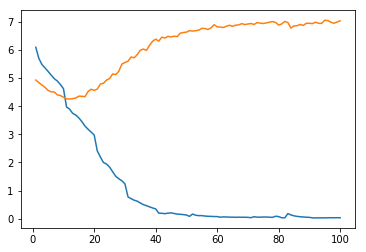

In [23]:
plot_loss(losses)

## reviews conditioned on genre

### genre tensor

In [24]:
#ALL_GENRES = list(set([GENRE_REGEX.sub('', genre.upper()) for list_genres in SAMPLE_DF.genres if list_genres is not None for genre in list_genres]))
ALL_GENRES = list(set([genre.upper() for list_genres in SAMPLE_DF.genres if list_genres is not None for genre in list_genres]))
N_GENRES = len(ALL_GENRES)
print(f'unique genres ({N_GENRES}): {ALL_GENRES}')

unique genres (6): ['NON-MUSIC', 'RAP', 'ROCK', 'R-B', 'COUNTRY', 'POP']


In [25]:
# one-hot tensor for genres
def oneHotGenre(genres):
    enc = torch.zeros(1, N_GENRES)
    if genres is None:
        return enc
    
    for genre in genres:
        #genre_idx = ALL_GENRES.index(GENRE_REGEX.sub('', genre.upper()))
        genre_idx = ALL_GENRES.index(genre.upper())
        enc[0][genre_idx] = 1

    return enc

print('r-b tensor:', oneHotGenre(['r-b']))

r-b tensor: tensor([[ 0.,  0.,  0.,  1.,  0.,  0.]])


In [41]:
def sample_fast_genre(model, seed='the song', genres=['pop'], sample=True):
    text_tensor = TEXT.numericalize([[tok.text for tok in spacy_tok(seed)]])
    genre_tensor = oneHotGenre(genres)
    print(VV(text_tensor.transpose(0,1)).size(), VV(genre_tensor.transpose(0,1)).size())
    set_trace()
    p = model(VV(text_tensor.transpose(0,1)), VV(genre_tensor.transpose(0,1)))
    if sample:
        r = torch.multinomial(p[-1].exp(), 1)
        return TEXT.vocab.itos[to_np(r)[0]]
    
    r = p[-1].topk(1)[1][0]
    return TEXT.vocab.itos[r.item()]

def sample_fast_genre_n(model, n, seed='the song', genres=['pop'], sample=True):
    res = seed
    for i in range(n):
        w = sample_fast_genre(model, seed, genres, sample)
        res += w + ' '
        seed = seed[1:]+w
    print(res)

In [ ]:
sample_fast_genre_n(genre_lstm, 100)

torch.Size([1, 2]) torch.Size([6, 1])
> <ipython-input-41-99c003c0afa6>(6)sample_fast_genre()
      4     print(VV(text_tensor.transpose(0,1)).size(), VV(genre_tensor.transpose(0,1)).size())
      5     set_trace()
----> 6     p = model(VV(text_tensor.transpose(0,1)), VV(genre_tensor.transpose(0,1)))
      7     if sample:
      8         r = torch.multinomial(p[-1].exp(), 1)

ipdb> down
*** Newest frame
ipdb> nxt
*** NameError: name 'nxt' is not defined
ipdb> next
RuntimeError: invalid argument 0: Tensors must have same number of dimensions: got 3 and 2 at /opt/conda/conda-bld/pytorch_1524586445097/work/aten/src/THC/generic/THCTensorMath.cu:102
> <ipython-input-41-99c003c0afa6>(6)sample_fast_genre()
      4     print(VV(text_tensor.transpose(0,1)).size(), VV(genre_tensor.transpose(0,1)).size())
      5     set_trace()
----> 6     p = model(VV(text_tensor.transpose(0,1)), VV(genre_tensor.transpose(0,1)))
      7     if sample:
      8         r = torch.multinomial(p[-1].exp(), 1)

ipdb

### adding genre to languagemodelloader

let's look at the current training data...

In [27]:
md.trn_ds.fields['text']

In [28]:
md.trn_dl.data

tensor([[   50,     0,     2,  ...,  1234,     8,  1429],
        [    5,    78,     0,  ...,     3,     5,     8],
        [  105,    24,    11,  ...,     0,     0,   436],
        ...,
        [    2,     0,    35,  ...,     2,  1169,     9],
        [    0,     0,     0,  ...,  1139,    86,    86],
        [    3,   103,     4,  ...,     0,    83,     3]], device='cuda:0')

In [29]:
list(zip(md.trn_ds[0].text[:20], TEXT.numericalize([md.trn_ds[0].text[:20]])))

[('all', tensor([ 50], device='cuda:0')),
 ('the', tensor([ 5], device='cuda:0')),
 ('time', tensor([ 105], device='cuda:0')),
 ('-', tensor([ 10], device='cuda:0')),
 ('bahamas', tensor([ 0], device='cuda:0')),
 ('.', tensor([ 4], device='cuda:0')),
 ('\n', tensor([ 2], device='cuda:0')),
 ('bahamas', tensor([ 0], device='cuda:0')),
 ('is', tensor([ 13], device='cuda:0')),
 ('the', tensor([ 5], device='cuda:0')),
 ('solo', tensor([ 439], device='cuda:0')),
 ('project', tensor([ 496], device='cuda:0')),
 ('of', tensor([ 8], device='cuda:0')),
 ('toronto', tensor([ 680], device='cuda:0')),
 ('-', tensor([ 10], device='cuda:0')),
 ('based', tensor([ 140], device='cuda:0')),
 ('guitarist', tensor([ 1237], device='cuda:0')),
 ('and', tensor([ 6], device='cuda:0')),
 ('musical', tensor([ 290], device='cuda:0')),
 ('gun', tensor([ 0], device='cuda:0'))]

TorchText allows `Dataset`s with multiple `Field`s.

Sadly, `fastai.nlp.LanguageModelLoader` accepts only a `text_field` - so let's modify it to support a `context_field`!

In [30]:
class ConcatTextAndContextDatasetFromDataFrames(torchtext.data.Dataset):
    # TODO: support multiple context columns
    def __init__(self, df, text_field, text_col, context_field, context_col, newline_eos=True, **kwargs):
        fields = [('text', text_field), ('context', context_field)]
        text = []

        #text += text_field.preprocess(df[text_col].str.cat(sep=' <eos> ')) # TODO: ' <eos> ' is being tokenized
        #if (newline_eos): text.append('<eos>')
        
        #words_per_text = []
        context_multiple = []
        texts = [text_field.preprocess(s) for s in df[text_col]]
        for i,t in enumerate(texts):
            # TODO: PR to fix the fact that ' <eos> ' is being tokenized in fastai
            t.append('<eos>')
            text += t
            #words_per_text.append(len(t))
            #for g,m in zip(df[context_col], words_per_text):
            context_multiple.extend([list(df[context_col])[i]] * len(t))
        
        #print(len(text), len(context_multiple))
        
        context = context_field.preprocess(context_multiple)

        examples = [torchtext.data.Example.fromlist([text, context], fields)]

        super().__init__(examples, fields, **kwargs)

    @classmethod
    def splits(cls, train_df=None, val_df=None, test_df=None, keep_nones=False, **kwargs):
        res = (
            cls(train_df, **kwargs),
            cls(val_df, **kwargs),
            map_none(test_df, partial(cls, **kwargs)))  # not required
        return res if keep_nones else tuple(d for d in res if d is not None)

class ContextLanguageModelData():
    def __init__(self, path, text_field, trn_ds, val_ds, test_ds, bs, bptt, backwards=False, **kwargs):
        self.bs = bs
        self.path = path
        self.trn_ds = trn_ds; self.val_ds = val_ds; self.test_ds = test_ds
        if not hasattr(text_field, 'vocab'): text_field.build_vocab(self.trn_ds, **kwargs)

        self.pad_idx = text_field.vocab.stoi[text_field.pad_token]
        self.nt = len(text_field.vocab)

        factory = lambda ds: ContextLanguageModelLoader(ds, bs, bptt, backwards=backwards)
        self.trn_dl = factory(self.trn_ds)
        self.val_dl = factory(self.val_ds)
        self.test_dl = map_none(self.test_ds, factory)  # not required

    def get_model(self, opt_fn, emb_sz, n_hid, n_layers, **kwargs):
        m = get_language_model(self.nt, emb_sz, n_hid, n_layers, self.pad_idx, **kwargs)
        model = SingleModel(to_gpu(m))
        return RNN_Learner(self, model, opt_fn=opt_fn)

    @classmethod
    def from_dataframes(cls, path, text_field, text_col, context_field, context_col, train_df, val_df, test_df=None, bs=64, bptt=70, **kwargs):
        trn_ds, val_ds, test_ds = ConcatTextAndContextDatasetFromDataFrames.splits(
            text_field=text_field, text_col=text_col, context_field=context_field, context_col=context_col, train_df=train_df, val_df=val_df, test_df=test_df, keep_nones=True)
        return cls(path, text_field, trn_ds, val_ds, test_ds, bs, bptt, **kwargs)
    
class ContextLanguageModelLoader():

    def __init__(self, ds, bs, bptt, backwards=False):
        self.bs,self.bptt,self.backwards = bs,bptt,backwards
        
        text = sum([o.text for o in ds], [])
        text_fld = ds.fields['text']
        
        # TODO: any number of extra Fields?
        context = torch.stack([oneHotGenre(c) for o in ds for c in o.context])
        #context_fld = ds.fields['context']
        
        text_nums = text_fld.numericalize([text], device=None if torch.cuda.is_available() else -1)
        # TODO: oneHotGenre as numericalize?
        context_nums = context
        
        self.text_data = self.batchify(text_nums)
        #self.context_data = self.batchify(context_nums)
        self.context_data = self.batchify_context(context_nums)
        
        self.i,self.iter = 0,0
        self.n = len(self.text_data)

    def __iter__(self):
        self.i,self.iter = 0,0
        return self

    def __len__(self): return self.n // self.bptt - 1

    def __next__(self):
        if self.i >= self.n-1 or self.iter>=len(self): raise StopIteration
        bptt = self.bptt if np.random.random() < 0.95 else self.bptt / 2.
        seq_len = max(5, int(np.random.normal(bptt, 5)))
        res = self.get_batch(self.i, seq_len)
        self.i += seq_len
        self.iter += 1
        return res

    def batchify(self, data):
        nb = data.size(0) // self.bs
        data = data[:nb*self.bs]
        data = data.view(self.bs, -1).t().contiguous()
        if self.backwards: data=flip_tensor(data, 0)
        return to_gpu(data)
    
    def batchify_context(self, data):
        nb = data.size(0) // self.bs
        data = data[:nb*self.bs]
        data = data.view(self.bs, -1, N_GENRES).t().contiguous()
        if self.backwards: data=flip_tensor(data, 0)
        return to_gpu(data)

    def get_batch(self, i, seq_len):
        source_text = self.text_data
        source_context = self.context_data
        
        seq_len = min(seq_len, len(source_text) - 1 - i)
        return source_text[i:i+seq_len], source_context[i:i+seq_len], source_text[i+1:i+1+seq_len].view(-1)

In [31]:
GENRES_FIELD = data.Field(sequential=False, use_vocab=False, eos_token='<eos>')

gmd = ContextLanguageModelData.from_dataframes('.', TEXT, 'content', GENRES_FIELD, 'genres', TRAIN_DF, VAL_DF, bs=BS, bptt=BPTT, min_freq=3)

len(gmd.trn_dl), gmd.nt, len(gmd.trn_ds), len(gmd.trn_ds[0].text)

(13, 1478, 1, 33390)

In [32]:
gmd.trn_dl.text_data.size(), gmd.trn_dl.context_data.size()

(torch.Size([521, 64]), torch.Size([521, 64, 6]))

In [33]:
gmd.trn_dl.text_data

tensor([[   50,    78,    11,  ...,    27,    37,    11],
        [    5,     0,     0,  ...,     2,     9,     0],
        [  105,   639,     0,  ...,   371,    30,     0],
        ...,
        [    0,   103,     0,  ...,     8,     0,   930],
        [    3,     2,     4,  ...,     0,   803,    16],
        [    0,     0,   852,  ...,    18,   202,    50]], device='cuda:0')

In [34]:
gmd.trn_dl.context_data

tensor([[[ 0.,  0.,  1.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  1.],
         ...,
         [ 0.,  0.,  0.,  0.,  0.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  1.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  1.],
         ...,
         [ 0.,  0.,  0.,  0.,  0.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  1.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  1.],
         ...,
         [ 0.,  0.,  0.,  0.,  0.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.]],

        ...,

        [[ 0.,  0.,  0.,  0.,  0.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  1.],
         [ 0.,  0.,  0.,  1.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  0.,  0.,  1.],
         [ 0.,  0.,  0

In [35]:
print(gmd.trn_ds[0].text[:12])
print(TEXT.numericalize([md.trn_ds[0].text[:12]]))
print(gmd.trn_ds[0].context[:12])

['all', 'the', 'time', '-', 'bahamas', '.', '\n', 'bahamas', 'is', 'the', 'solo', 'project']
tensor([[  50],
        [   5],
        [ 105],
        [  10],
        [   0],
        [   4],
        [   2],
        [   0],
        [  13],
        [   5],
        [ 439],
        [ 496]], device='cuda:0')
[['rock'], ['rock'], ['rock'], ['rock'], ['rock'], ['rock'], ['rock'], ['rock'], ['rock'], ['rock'], ['rock'], ['rock']]


In [36]:
TEXT.vocab.itos[:12]

['<unk>', '<pad>', '\n', ',', '.', 'the', 'and', 'a', 'of', 'to', '-', "'s"]

### training

In [37]:
class GenreLSTM(nn.Module):
    def __init__(self, vocab_size, n_genres, hidden_size, n_emb, batch_size, num_layers):
        super(GenreLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, n_emb)
        self.rnn = nn.LSTM(n_genres + n_emb, hidden_size, num_layers, dropout=0.5)
        self.l_out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.init_hidden(batch_size)
        
    def forward(self, inputs, genres):
        bs = inputs[0].size(0)
        if self.hidden[0].size(1) != bs: self.init_hidden(bs)
        
        #inputs_combined = torch.cat((genres, inputs.view(-1, bs, 1)), -1)
        #inputs_combined = self.embedding(inputs_combined)
        inputs = self.embedding(inputs)
        inputs_combined = torch.cat((genres, inputs), -1)
        output, hidden = self.rnn(inputs_combined, self.hidden)
        self.hidden = [h.detach() for h in hidden]
        output = self.l_out(output)
        output = self.softmax(output)
        
        return output.view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.batch_size = bs
        self.hidden = (V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)),
                  V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)))

In [38]:
genre_lstm = GenreLSTM(gmd.nt, N_GENRES, N_HIDDEN, N_EMB, BS, N_LAYERS).to(DEVICE)
g_lo = LayerOptimizer(optim.Adam, genre_lstm, 1e-2, 1e-6)

losses = []
for i in range(10):
    cb = [CosAnneal(g_lo, len(gmd.trn_dl), cycle_mult=2)]
    losses.append(fit(genre_lstm, gmd, 10, g_lo.opt, F.nll_loss, get_ep_vals=True, callbacks=cb)[1]) # save all_epoch_losses
    sample_fast_genre_n(genre_lstm, 100)

epoch      trn_loss   val_loss                            
    0      6.141955   4.990801  
    1      5.737193   4.915253                            
    2      5.526495   4.869303                            
    3      5.415534   4.805818                            
    4      5.306456   4.681397                            
    5      5.189993   4.61974                             
    6      5.088583   4.623262                            
    7      5.005951   4.520332                            
    8      4.906327   4.441175                            
    9      4.787345   4.388851                            

torch.Size([2, 1]) torch.Size([1, 6])


RuntimeError: invalid argument 0: Tensors must have same number of dimensions: got 3 and 2 at /opt/conda/conda-bld/pytorch_1524586445097/work/aten/src/THC/generic/THCTensorMath.cu:102